## Neural network: wind-ice angle prediction

This notebook entails the process for predicting the angles between the wind velocity vector and the sea ice drift vector. The experimentation was done in Google Colab, so a few remnants of that should be visible in the code, but can be replaced easily with own folder paths or names.

In [1]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from tensorflow.keras.layers.experimental import preprocessing

mpl.rcParams['figure.figsize'] = (10, 8)
mpl.rcParams['axes.grid'] = False

In [2]:
# load the dataset from Drive:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# load from drive folder (on Google Colab)
drift_data_test = pd.read_csv('/content/drive/MyDrive/Hackathon/DRIFT_DATA_TEST.csv')
drift_data_train = pd.read_csv('/content/drive/MyDrive/Hackathon/DRIFT_DATA_TRAIN.csv')

In [ ]:
drift_data_train.head()

,year,month,day,doy,x_EASE,y_EASE,u_buoy,v_buoy,id_buoy,u_ERA5,v_ERA5,sic_CDR,h_cs2smos,h_piomas,d2c
0,1979,2,18,49,147.506958,138.582672,-0.797554,1.114740,1906,-6.704156,-0.321260,0.990195,NaN,3.189743,522.523298
1,1979,2,18,49,146.834778,120.509880,0.643200,0.368754,1913,-6.818630,-0.674205,0.966372,NaN,2.484009,412.767669
2,1979,2,18,49,130.993561,129.623672,-1.162420,0.243717,1914,-8.825469,1.123955,0.996022,NaN,2.474106,362.547379
3,1979,2,18,49,147.524719,157.382492,0.919766,0.025784,1918,-1.079951,-1.035410,0.982681,NaN,3.740522,381.025629
4,1979,2,19,50,147.470963,138.599823,0.380940,1.243485,1906,-2.169171,2.537787,0.990302,NaN,3.188522,521.535334


In [ ]:
drift_data_test.head()

,year,month,day,doy,x_EASE,y_EASE,u_buoy,v_buoy,id_buoy,u_ERA5,v_ERA5,sic_CDR,h_cs2smos,h_piomas,d2c
0,1979,2,18,49,197.656311,204.507797,NaN,NaN,NaN,5.998414,3.617303,0.987723,NaN,2.535649,375.766965
1,1979,2,19,50,197.769897,204.840912,NaN,NaN,NaN,-1.414826,-0.201038,0.964051,NaN,2.539519,370.636136
2,1979,2,19,50,147.548553,157.382889,NaN,NaN,NaN,-4.140861,3.038851,1.000000,NaN,3.746467,381.590523
3,1979,2,20,51,146.934814,120.546783,NaN,NaN,NaN,2.998362,4.055094,1.000000,NaN,2.496566,413.672796
4,1979,2,21,52,197.534439,204.845886,NaN,NaN,NaN,-8.538108,4.243983,0.978987,NaN,2.530706,376.255493


In [ ]:
drift_data_train.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
year,339478.0,2007.013774,9.822726,1979.000000,2000.000000,2009.000000,2015.000000,2019.000000
month,339478.0,6.749374,3.454148,1.000000,4.000000,7.000000,10.000000,12.000000
day,339478.0,15.744955,8.752622,1.000000,8.000000,16.000000,23.000000,31.000000
doy,339478.0,190.020314,105.562830,1.000000,101.000000,190.000000,285.000000,364.000000
x_EASE,339478.0,163.595093,24.451743,39.168983,146.809723,161.223709,181.115864,279.391541
y_EASE,339478.0,156.507375,34.697790,36.870293,129.208836,152.350731,179.608978,279.562073
u_buoy,339478.0,-0.333029,8.072700,-74.682899,-3.722860,-0.024725,2.942216,68.396103
v_buoy,339478.0,1.359709,7.860918,-66.781601,-2.325024,0.322306,4.969131,68.639801
id_buoy,339478.0,35576.107397,31444.526635,0.000000,7408.000000,26150.000000,64878.000000,99800.000000
u_ERA5,339478.0,-0.096208,4.319904,-23.084634,-3.149262,-0.165074,2.934149,17.911558


In [ ]:
date_time = pd.to_datetime(["{}.{}.{}".format(day, month, year) for day, month, year 
 in zip(drift_data_train.day, drift_data_train.month, drift_data_train.year)], format='%d.%m.%Y')

In [4]:
# include the periodicity/seasonality information from the Fourier analysis:
drift_data_train["year_sin"] = np.sin(drift_data_train["doy"] * (2 * np.pi / 364))
drift_data_train["year_cos"] = np.cos(drift_data_train["doy"] * (2 * np.pi / 364))

# include norm of the wind velocities as data:
drift_data_train["wind_norm"] = np.sqrt(drift_data_train["u_ERA5"].values**2 + drift_data_train["v_ERA5"].values**2)

**Train-test split:**

In [5]:
import math

from sklearn.model_selection import train_test_split

data = drift_data_train[["year_sin", "year_cos", "wind_norm", "x_EASE",	"y_EASE",	"u_buoy",	"v_buoy",	"u_ERA5",	"v_ERA5",	"sic_CDR",	"h_piomas",	"d2c"]]

# split the data:
train, test = train_test_split(data, test_size=0.2)

**Options for the training set:**

In [6]:
# using all standard variables + sin/cos:
train_set = train[["year_sin", "year_cos", "x_EASE",	"y_EASE", "u_ERA5",	"v_ERA5",	"sic_CDR", "h_piomas",	"d2c"]].copy(deep=True)

# Experimental train_sets:
# train_set = train[["x_EASE",	"y_EASE", "u_ERA5",	"v_ERA5",	"sic_CDR",	"h_piomas",	"d2c"]]  # no forced seasonality
# train_set = train[["year_sin", "year_cos", "wind_norm", "x_EASE",	"y_EASE", "u_ERA5",	"v_ERA5",	"sic_CDR",	"h_piomas",	"d2c"]]  # add wind_norm
# train_set = train[["year_sin", "year_cos", "wind_norm", "x_EASE",	"y_EASE",	"sic_CDR",	"h_piomas",	"d2c"]]  # only windnorm, no x, y components
# train_set = train[["u_ERA5",	"v_ERA5"]]  # check relationship by using only the wind velocities

# for the training labels, we calculate the actual angles between the wind an ice velocities:

train_labels = np.zeros(len(train))
zero_velocities = []

for i in range(len(train)):
  U_i_true = train[["u_buoy",	"v_buoy"]].values[i]  # true ice velocity vector

  # we skip the samples that have norm close to zero, since no angle can be inferred from them:
  if not math.isclose(np.linalg.norm(U_i_true), 0):

    U_i_true_norm = U_i_true / np.linalg.norm(U_i_true)  # normalize

    U_a = train[["u_ERA5",	"v_ERA5"]].values[i]  # wind vector
    U_a_norm = U_a / np.linalg.norm(U_a)

    dot_product = np.clip(np.dot(U_i_true_norm, U_a_norm), -0.9999, 0.9999)

    angle = math.acos(dot_product)
    train_labels[i] = angle

  else:
    zero_velocities.append(i)

**Same options for the test set:**

In [8]:
test_set = test[["year_sin", "year_cos", "x_EASE",	"y_EASE", "u_ERA5",	"v_ERA5",	"sic_CDR",	"h_piomas",	"d2c"]].copy(deep=True)
# test_set = test[["x_EASE",	"y_EASE", "u_ERA5",	"v_ERA5",	"sic_CDR",	"h_piomas",	"d2c"]]
# test_set = test[["year_sin", "year_cos", "wind_norm", "x_EASE",	"y_EASE", "u_ERA5",	"v_ERA5",	"sic_CDR",	"h_piomas",	"d2c"]]
# test_set = test[["year_sin", "year_cos", "wind_norm", "x_EASE",	"y_EASE", "sic_CDR",	"h_piomas",	"d2c"]]
# test_set = test[["u_ERA5",	"v_ERA5"]]

test_labels = np.zeros(len(test))
zero_velocities_test = []

for i in range(len(test)):
  U_i_true = test[["u_buoy",	"v_buoy"]].values[i]  # true ice velocity vector

  # we skip the samples that have norm close to zero, since no angle can be inferred from them:
  if not math.isclose(np.linalg.norm(U_i_true), 0):

    U_i_true_norm = U_i_true / np.linalg.norm(U_i_true)  # normalize

    U_a = test[["u_ERA5",	"v_ERA5"]].values[i]  # wind vector
    U_a_norm = U_a / np.linalg.norm(U_a)

    dot_product = np.clip(np.dot(U_i_true_norm, U_a_norm), -0.9999, 0.9999)

    angle = math.acos(dot_product)
    test_labels[i] = angle

  else:
    zero_velocities_test.append(i)

We drop the data samples for training that have a zero length ice velocity vector, since no angle can be inferred from them and thus no labels are available. The final model, however, will always predict an angle, so this does not deduce the generality of the model.

In [9]:
train_set_ = train_set.reset_index().drop(index=np.array(zero_velocities))
train_labels_ = np.delete(train_labels, zero_velocities)

test_set_ = test_set.reset_index().drop(index=np.array(zero_velocities_test))
test_labels_ = np.delete(test_labels, zero_velocities_test)

In [10]:
# remove the indices (artefact from reset_index function in last cell):
train_set_ = train_set_.drop(["index"], axis=1)
test_set_ = test_set_.drop(["index"], axis=1)

**Building the neural network**

In [11]:
# normalization of input variables:
normalizer = preprocessing.Normalization()
normalizer.adapt(np.array(train_set_))

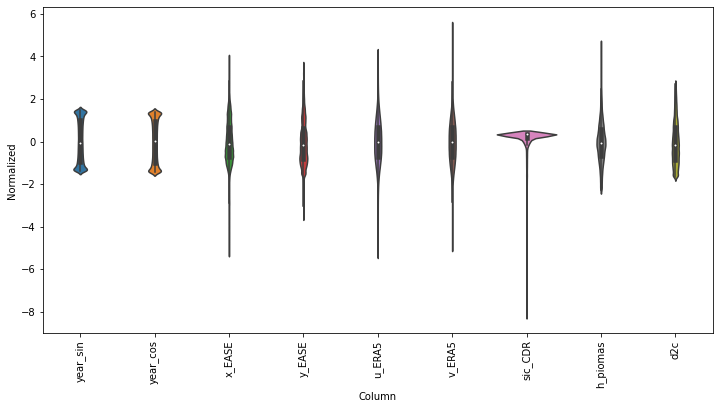

In [12]:
# # visualize normalized data ranges:
df_std = pd.DataFrame(np.array(normalizer(train_set))).melt(var_name='Column', value_name='Normalized')

plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(train_set.keys(), rotation=90)

We center the outputs as well for better performance. It's important to note that the outputs of the neural network afterwards need to be decentered with '`+ norm_mean`' afterwards for sensible predictions! This centering does not influence the difference between the labels and the predictions, so this has no influence on the error, except for making it easier for the model to predict the angles (since a neural network likes symmetric outputs).

In [13]:
# centering the outputs as well:
norm_mean = np.mean(train_labels_)
norm_stdev = np.std(train_labels_)
print(norm_mean)
print(norm_stdev)

train_labels_ = (train_labels_ - norm_mean)
test_labels_ = (test_labels_ - norm_mean)

0.7203469126026589
0.6677393613595433


We build the custom root mean square loss function that is specified as the criterion by Charles Brunette:

In [14]:
from keras import backend as K

def root_mean_squared_error(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true))) 

In [15]:
# Define Sequential model with 3 layers
model = keras.Sequential(
    [
        normalizer,
        layers.Dense(128, activation="relu"),
        layers.Dense(128, activation="relu"),
        layers.Dense(64, activation="relu"),
        layers.Dense(32, activation="relu"),
        layers.Dense(1),
    ])

model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.001),
    loss=root_mean_squared_error,
    # loss="mse",
    )

**All right, let's train!**

In [ ]:
history = model.fit(
    x=train_set_, y=train_labels_,
    epochs=100,
    verbose=1,
    validation_split = 0.2
    )

Let's test our trained model on our held-out test samples:

In [17]:
test_predictions = model.predict(test_set_)

Calculate the root mean square error, the mean absolute error and the mean error:

In [18]:
### for angles with scaled outputs:
preds = np.array(test_predictions).flatten() + norm_mean

rmse_errors = []
mae_errors = []
me_errors = []
for i, pred in enumerate(preds):
  mae_errors.append(np.abs(pred - (test_labels_[i] + norm_mean)))
  me_errors.append(pred - (test_labels_[i] + norm_mean))
  rmse_errors.append((pred - (test_labels_[i] + norm_mean))**2)

print("rmse: ", np.sqrt(np.mean(rmse_errors)))
print("mae: ", np.mean(mae_errors))
print("me: ", np.mean(me_errors))

print("average angle: ", np.mean(preds))

rmse:  0.5558514473614495
mae:  0.38829726208300036
me:  0.009517099897120856
average angle:  0.7338952


In [19]:
def convert_to_degrees(angles):
  return np.array(angles) * 360 / (2 * np.pi)

In [20]:
### for angles with scaled outputs and converted to degrees:
preds = convert_to_degrees(np.array(test_predictions).flatten() + norm_mean)
test_labs = convert_to_degrees(test_labels_ + norm_mean)

rmse_errors = []
mae_errors = []
me_errors = []
for i, pred in enumerate(preds):
  mae_errors.append(np.abs(pred - test_labs[i]))
  me_errors.append(pred - test_labs[i])
  rmse_errors.append((pred - test_labs[i])**2)

print("rmse: ", np.sqrt(np.mean(rmse_errors)))
print("mae: ", np.mean(mae_errors))
print("me: ", np.mean(me_errors))

print("average angle: ", np.mean(preds))

rmse:  31.847941924090193
mae:  22.24779412578568
me:  0.5452884841150368
average angle:  42.049095


In [21]:
print("true average angle: ", np.mean(test_labs))

true average angle:  41.50380495049324


## Submission test

The following code is for inferencing on the actual test set for which we don't have labels (i.e., the one we have to submit):

In [ ]:
# include the periodicity/seasonality information from the Fourier analysis:
drift_data_test["year_sin"] = np.sin(drift_data_test["doy"] * (2 * np.pi / 364))
drift_data_test["year_cos"] = np.cos(drift_data_test["doy"] * (2 * np.pi / 364))

actual_test_set = drift_data_test[["year_sin", "year_cos", "x_EASE",	"y_EASE", "u_ERA5",	"v_ERA5",	"sic_CDR",	"h_piomas",	"d2c"]].copy(deep=True)

In [ ]:
actual_test_predictions = model.predict(actual_test_set)
actual_test_predictions = np.array(actual_test_predictions + norm_mean)

Let's write our predictions to disk and download them:

In [ ]:
write_away = drift_data_test.drop(["year_sin", "year_cos"], axis=1)
write_away["angle_wind_ice"] = actual_test_predictions
write_away.to_csv("predictions_angle.csv")

In [ ]:
model.save('/content/model')

Let's download the model as well:

In [ ]:
!zip -r /content/model.zip /content/model